# Investigating Predictors of Acres Burned by Wildfires
## Math 748: Statistical and Machine Learning
### Sequoia Andrade

# Introduction
With climate change-driven large, destructive wildfires becoming more frequent, especially in California, using data to identify predictors of wildfire destruction can provide insight onto the influences of this trend. Additionally, identifying effective prevention methods, such as prescribed burns, can inform future preparations. Numerous datasets have been made public in recent years, including detailed tree-level data from national parks in addition to incident reports from large wildfire events. Statistical data science methods provide tools for making sense of the immense heterogeneous data relevant to wildfires. In this project, I will analyze predictors of wildfire acres burned in California using supervised statistical and machine learning techniques. This report covers the datset creation method and exploratory analysis. 

# Data

The dataset used in this project was manually created by bridging three main data sources: the Calfire record of wildfire incidents, the record of prescribed burn incidents, and climate data collected by NOAA. The resulting dataset contains a row for each month, spaning from 2016-2022, resulting in a total of 86 rows over the seven years of data. Only the wildfire and prescribed burn data have missing values, which are filled in as 0.

| Variable | Source | Description | Range | Units|
|----------|--------|-------------|-------|------|
|Acres Burned| CALfire | Wildfire acres burned | 0+ | Acres|
|Treatment Acres| CALfire | Prescribed fire acres burned | 0+ | Acres|
|Soil Moisture| NOAA | Soil moisture levels calculated based on temperature and precipitation | -500 to 500 | mm|
|Precipitation | NOAA | Monthly precipitation averaged across the state | 0+| inches|
|Temperature | NOAA | Average, minimum, and maximum temperature averaged across the state | 0+ | Farenhiet|
|Palmer Index | NOAA | Drought Severity index, hydrological drought index, modified drought index, Z-index | -10 to 10| NA|

## Wildfire Data

The wildfire dataset used in this project comes from the calfire incident record (available at https://incidents.fire.ca.gov/imapdata/mapdataall.csv ). The wildfire data has a row for each fire incident and includes data for acres burned, location, start date, and end date. Initial exploration found that the end date is unreliable with many reports from 2017 grouped into ending in 2018. Feature engineering is performed on the wildfire data to get a rolling average of the prior 3, 6, 9, and 12 months of total prescribed acres burned.

## Prescribed Burns Data

The prescribed burn dataset also comes from calfire and spans from 1950 to present (available at https://data.ca.gov/dataset/prescribed-burns). Each row is a prescribed burn incident and includes the date, location, geographic polygon, and acres burned.

## Climate Data

Climate data is gathered primarily from NOAA (available at https://www.ncei.noaa.gov/access/monitoring/climate-at-a-glance/statewide/time-series). Monthly data is gathered for the state of California across the available variables: soil moisture, temperature average, temperature max, temperature min, cooling days, heating days, precipitation, and drought indexes. Each variable contains monthly average and anaomoly data. 

In [1]:
import pandas as pd
import plotly.express as px
import matplotlib.pyplot as plt
plt.style.use("ggplot")
import numpy as np 
import matplotlib.dates as mdates
import os
import datetime
import xarray as xr
from calendar import monthrange
import rioxarray
import geopandas as gpd
import math
import cartopy.crs as ccrs
import cartopy.feature as cfeature

In [2]:
def convert_acres_degrees(acres, latitude):
    r_meters = math.sqrt((4046*acres)/math.pi)
    r_decimal = r_meters / (111.32 * 1000 * math.cos(latitude * (math.pi / 180)))
    return r_decimal

In [3]:
# loading wildfire data

# calfire data
df = pd.read_csv("mapdataall.csv")
df["acres_decimal"] = [convert_acres_degrees(df.at[i,"incident_acres_burned"], df.at[i, "incident_latitude"]) for i in range(len(df))]
df["incident_date_created"] = pd.to_datetime(df["incident_date_created"].fillna(df["incident_date_extinguished"]))
df["ex_date"] = pd.to_datetime(df["incident_date_created"])
df = df.set_index("ex_date")
df = df.loc['2016-01-01':'2022-12-31']
wildfire_monthly_acres_df = df[["incident_acres_burned"]].resample('M').sum()

C:\Users\sequo\AppData\Local\Temp\ipykernel_16972\3983013501.py:9: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  df = df.loc['2016-01-01':'2022-12-31']


In [4]:
# loading prescribed burn data
gdf = gpd.read_file("California_Fire_Perimeters_(all).geojson")
gdf["lon_center"] = gdf["geometry"].centroid.x
gdf["lat_center"] = gdf["geometry"].centroid.y
gdf["acres_decimal"] = [convert_acres_degrees(gdf.at[i,"TREATED_AC"], gdf.at[i, "lat_center"]) for i in range(len(gdf))]

gdf = gdf.fillna(0)

#gdf = gdf.sort_values('START_DATE', ascending=True)
gdf["START_DATE"] = pd.to_datetime(gdf["START_DATE"], errors = 'coerce')
gdf = gdf.sort_values('START_DATE', ascending=True)
gdf = gdf.set_index("START_DATE")
gdf_mon = gdf[["TREATED_AC"]].resample('M').sum()
gdf_mon = gdf_mon.loc['2015-01-01':'2022-12-31']

C:\Users\sequo\AppData\Local\Temp\ipykernel_16972\4117250769.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon_center"] = gdf["geometry"].centroid.x
C:\Users\sequo\AppData\Local\Temp\ipykernel_16972\4117250769.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat_center"] = gdf["geometry"].centroid.y


In [5]:
# feature engineering

# prescribed acres in past 3 months
gdf_mon["acres_3_month"] = [gdf_mon.loc[i - pd.DateOffset(months=4):i- pd.DateOffset(months=1)]["TREATED_AC"].sum() for i in gdf_mon.index]
# prescribed acres in past 6 months
gdf_mon["acres_6_month"] = [gdf_mon.loc[i - pd.DateOffset(months=7):i- pd.DateOffset(months=1)]["TREATED_AC"].sum() for i in gdf_mon.index]
# prescribed acres in past 9 months
gdf_mon["acres_9_month"] = [gdf_mon.loc[i - pd.DateOffset(months=10):i- pd.DateOffset(months=1)]["TREATED_AC"].sum() for i in gdf_mon.index]
# prescribed acres in past 12 months
gdf_mon["acres_12_month"] = [gdf_mon.loc[i - pd.DateOffset(months=13):i- pd.DateOffset(months=1)]["TREATED_AC"].sum() for i in gdf_mon.index]

In [6]:
prescribed_monthly = gdf_mon.loc['2016-01-01':'2022-12-31']

In [7]:
# climate data

# soil moisture
def get_monthly_soil(file=r"C:\Users\sequo\OneDrive\Desktop\thesis\soil moisture\soilw.mon.mean.nc"):
    ds = xr.open_dataset(file)
    monthly_temp = pd.DataFrame({"soil moisture":[]})
    shp_data = gpd.read_file('USA.shp') #USA.shp
    aoi = shp_data[shp_data['state_code']=='CA'].reset_index()
    ds = ds.assign_coords(lon=(((ds.lon + 180) % 360) - 180))
    bounds = aoi.bounds
    min_lat = bounds.miny.values[0]
    max_lat = bounds.maxy.values[0]
    min_lon = bounds.minx.values[0]
    max_lon = bounds.maxx.values[0]
    ds = ds.where((ds.lat > min_lat) & (ds.lat < max_lat), drop=True)
    ds = ds.where((ds.lon > min_lon) & (ds.lon < max_lon), drop=True)
    ds = ds.where((ds.time > np.datetime64("2014-12")) & (ds.time < np.datetime64("2023")), drop=True)
    temps = np.average(np.nanmean(ds.soilw.data, axis=1), axis=1)
    monthly_temp["soil moisture"] = temps
    ind = pd.date_range(start='1/1/2015', end='1/1/2023', freq='M')
    monthly_temp = monthly_temp.set_index(ind)
    return monthly_temp

soil = get_monthly_soil(r"C:\Users\sequo\OneDrive\Desktop\thesis\soil moisture\soilw.mon.mean.nc").loc['2016-01-01':'2022-12-31']
# temp avg
temp_avg = pd.read_csv("avg_temp.csv", header=4)
temp_avg["date_clean"] = [datetime.datetime(int(str(temp_avg.at[i,"Date"])[0:4]), int(str(temp_avg.at[i,"Date"])[4:]), monthrange(int(str(temp_avg.at[i,"Date"])[0:4]), int(str(temp_avg.at[i,"Date"])[4:]))[1]) for i in range(len(temp_avg))]
temp_avg = temp_avg.set_index("date_clean").drop(["Date"], axis=1)
temp_avg.columns = ["temp_avg_"+col for col in temp_avg.columns]
temp_avg = temp_avg.loc['2016-01-01':'2022-12-31']
# temp min
temp_min = pd.read_csv("temp_min.csv", header=4)
temp_min["date_clean"] = [datetime.datetime(int(str(temp_min.at[i,"Date"])[0:4]), int(str(temp_min.at[i,"Date"])[4:]), monthrange(int(str(temp_min.at[i,"Date"])[0:4]), int(str(temp_min.at[i,"Date"])[4:]))[1]) for i in range(len(temp_min))]
temp_min = temp_min.set_index("date_clean").drop(["Date"], axis=1)
temp_min.columns = ["temp_min_"+col for col in temp_min.columns]
temp_min = temp_min.loc['2016-01-01':'2022-12-31']
# temp max
temp_max = pd.read_csv("temp_max.csv", header=4)
temp_max["date_clean"] = [datetime.datetime(int(str(temp_max.at[i,"Date"])[0:4]), int(str(temp_max.at[i,"Date"])[4:]), monthrange(int(str(temp_max.at[i,"Date"])[0:4]), int(str(temp_max.at[i,"Date"])[4:]))[1]) for i in range(len(temp_max))]
temp_max = temp_max.set_index("date_clean").drop(["Date"], axis=1)
temp_max.columns = ["temp_max_"+col for col in temp_max.columns]
temp_max = temp_max.loc['2016-01-01':'2022-12-31']
# precip
precip_new = pd.read_csv("precip_new.csv", header=4)
precip_new["date_clean"] = [datetime.datetime(int(str(precip_new.at[i,"Date"])[0:4]), int(str(precip_new.at[i,"Date"])[4:]), monthrange(int(str(precip_new.at[i,"Date"])[0:4]), int(str(precip_new.at[i,"Date"])[4:]))[1]) for i in range(len(precip_new))]
precip_new = precip_new.set_index("date_clean").drop(["Date"], axis=1)
precip_new.columns = ["precip_new_"+col for col in precip_new.columns]
precip_new = precip_new.loc['2016-01-01':'2022-12-31']
# phdi
phdi = pd.read_csv("phdi.csv", header=3)
phdi["date_clean"] = [datetime.datetime(int(str(phdi.at[i,"Date"])[0:4]), int(str(phdi.at[i,"Date"])[4:]), monthrange(int(str(phdi.at[i,"Date"])[0:4]), int(str(phdi.at[i,"Date"])[4:]))[1]) for i in range(len(phdi))]
phdi = phdi.set_index("date_clean").drop(["Date"], axis=1)
phdi.columns = ["phdi_"+col for col in phdi.columns]
phdi = phdi.loc['2016-01-01':'2022-12-31']
# pdsi
pdsi = pd.read_csv("pdsi.csv", header=3)
pdsi["date_clean"] = [datetime.datetime(int(str(pdsi.at[i,"Date"])[0:4]), int(str(pdsi.at[i,"Date"])[4:]), monthrange(int(str(pdsi.at[i,"Date"])[0:4]), int(str(pdsi.at[i,"Date"])[4:]))[1]) for i in range(len(pdsi))]
pdsi = pdsi.set_index("date_clean").drop(["Date"], axis=1)
pdsi.columns = ["pdsi_"+col for col in pdsi.columns]
pdsi = pdsi.loc['2016-01-01':'2022-12-31']
# pmdi
pmdi = pd.read_csv("pmdi.csv", header=3)
pmdi["date_clean"] = [datetime.datetime(int(str(pmdi.at[i,"Date"])[0:4]), int(str(pmdi.at[i,"Date"])[4:]), monthrange(int(str(pmdi.at[i,"Date"])[0:4]), int(str(pmdi.at[i,"Date"])[4:]))[1]) for i in range(len(pmdi))]
pmdi = pmdi.set_index("date_clean").drop(["Date"], axis=1)
pmdi.columns = ["pmdi_"+col for col in pmdi.columns]
pmdi = pmdi.loc['2016-01-01':'2022-12-31']
# pzi
pzi = pd.read_csv("pzi.csv", header=3)
pzi["date_clean"] = [datetime.datetime(int(str(pzi.at[i,"Date"])[0:4]), int(str(pzi.at[i,"Date"])[4:]), monthrange(int(str(pzi.at[i,"Date"])[0:4]), int(str(pzi.at[i,"Date"])[4:]))[1]) for i in range(len(pzi))]
pzi = pzi.set_index("date_clean").drop(["Date"], axis=1)
pzi.columns = ["pzi_"+col for col in pzi.columns]
pzi = pzi.loc['2016-01-01':'2022-12-31']
# heating days
heating = pd.read_csv("cooling.csv", header=4)
heating["date_clean"] = [datetime.datetime(int(str(heating.at[i,"Date"])[0:4]), int(str(heating.at[i,"Date"])[4:]), monthrange(int(str(heating.at[i,"Date"])[0:4]), int(str(heating.at[i,"Date"])[4:]))[1]) for i in range(len(heating))]
heating = heating.set_index("date_clean").drop(["Date"], axis=1)
heating.columns = ["heating_days"+col for col in heating.columns]
heating = heating.loc['2016-01-01':'2022-12-31']
# cooling days
cooling = pd.read_csv("cooling.csv", header=4)
cooling["date_clean"] = [datetime.datetime(int(str(cooling.at[i,"Date"])[0:4]), int(str(cooling.at[i,"Date"])[4:]), monthrange(int(str(cooling.at[i,"Date"])[0:4]), int(str(cooling.at[i,"Date"])[4:]))[1]) for i in range(len(cooling))]
cooling = cooling.set_index("date_clean").drop(["Date"], axis=1)
cooling.columns = ["cooling_days"+col for col in cooling.columns]
cooling = cooling.loc['2016-01-01':'2022-12-31']

In [8]:
#combine
pd.concat([wildfire_monthly_acres_df.tz_localize(None), prescribed_monthly.tz_localize(None), 
           soil.tz_localize(None), temp_avg.tz_localize(None), temp_min.tz_localize(None), 
           temp_max.tz_localize(None), precip_new.tz_localize(None), pdsi.tz_localize(None), 
           phdi.tz_localize(None), pmdi.tz_localize(None), pzi.tz_localize(None), 
           cooling.tz_localize(None), heating.tz_localize(None)], axis=1).fillna(0).to_csv("wildfire_data.csv")

# Exploratory Analysis

## Individual Datasets
- wildfire incidents map
- prescribed burn incidents map
- distribution over years
- distribution over months

From the initial exploratory analysis we can see that wildfires peak from June to September, while prescribed fires peak from October to December. With this in mind, comparing the amount of prescribed and wildland fire acres burned in the same month may not make sense for a predictor. Instead, using an engineered predictor for prescribed fires, such as the acres burned in previous months or different lag amounts, would make more sense. The greatest amount of wildfire acres burned occured in 2019, while 2017 saw the greatest amount of prescribed fire acres. It also appears that the number of wildland fire acres is increasing in the small year range observed, with 2016 and 2017 having the fewest acres burned. In contrast, the amount of prescribed burn acres could be decreasing, but it is difficult to tell. The maps of prescribed and wildland fires do not show any clear trends. Ideally if prescribed burns are effective, there would be fewer and smaller wildland fires near by. 

In [9]:
df["year"] = df.index.year 
df["month"] = df.index.month

gdf = gdf.loc['2016-01-01':'2022-12-31']
gdf["year"] = gdf.index.year
gdf["month"] = gdf.index.month

C:\Users\sequo\AppData\Local\Temp\ipykernel_16972\3546275999.py:4: FutureWarning: Value based partial slicing on non-monotonic DatetimeIndexes with non-existing keys is deprecated and will raise a KeyError in a future Version.
  gdf = gdf.loc['2016-01-01':'2022-12-31']


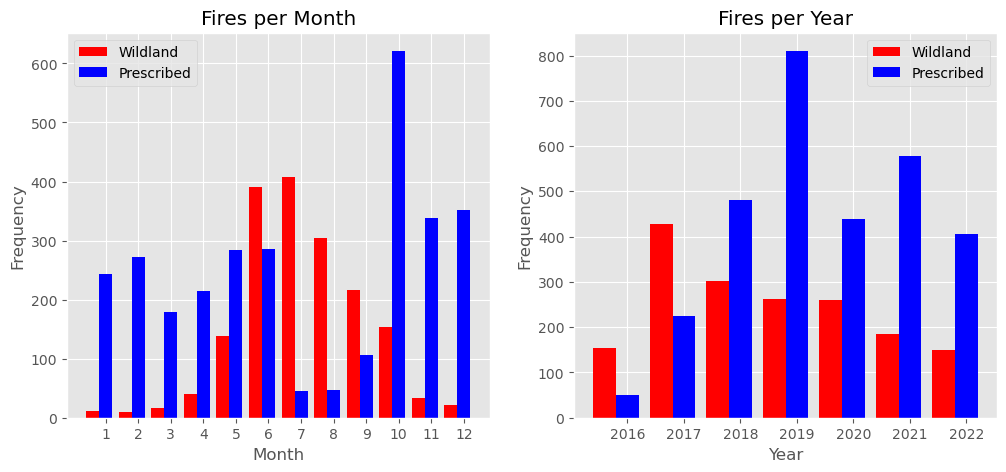

In [10]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
x = np.arange(len(df["month"].value_counts()))  # the label locations
width = 0.4
ax[0].bar(x, list(df["month"].value_counts().sort_index().values), width, color="red", label="Wildland")
ax[0].bar(x+width, list(gdf["month"].value_counts().sort_index().values), width, color="blue", label="Prescribed")
ax[0].set_xticks(x + width, list(df["month"].value_counts().sort_index().index))
ax[0].set_title("Fires per Month")
ax[0].set_xlabel("Month")
ax[0].set_ylabel("Frequency")
ax[0].legend()

x = np.arange(len(df["year"].value_counts()))  # the label locations
width = 0.4
ax[1].bar(x, list(df["year"].value_counts().sort_index().values), width, color="red", label="Wildland")
ax[1].bar(x+width, list(gdf["year"].value_counts().sort_index().values), width, color="blue", label="Prescribed")
ax[1].set_xticks(x + width, list(df["year"].value_counts().sort_index().index))
ax[1].set_title("Fires per Year")
ax[1].set_xlabel("Year")
ax[1].set_ylabel("Frequency")
ax[1].legend()
plt.show()


In [11]:
gdf["lon_center"] = gdf["geometry"].centroid.x
gdf["lat_center"] = gdf["geometry"].centroid.y
gdf["YEAR_"] = gdf["YEAR_"].astype(int)
gdf = gdf.fillna(0)

C:\Users\sequo\AppData\Local\Temp\ipykernel_16972\344453164.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lon_center"] = gdf["geometry"].centroid.x
C:\Users\sequo\AppData\Local\Temp\ipykernel_16972\344453164.py:2: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  gdf["lat_center"] = gdf["geometry"].centroid.y


In [12]:
def plot_rx_wild_fires_multi_year(prescribed, wild, years):
    nrows = max(int(np.ceil(len(years)/2)),2)
    ncols = 2
    figsize_x = ncols*6
    figsize_y = nrows*6
    fig, ax = plt.subplots(nrows, ncols, figsize=(figsize_x,figsize_y), subplot_kw={'projection': ccrs.PlateCarree()})
    curr_row = 0
    curr_col = 0
    poly = gpd.read_file("California_County_Boundaries.geojson")["geometry"]
    wild_colors = ["red", "orange", "yellow"]
    for year in years:
        curr_prescribed = prescribed.loc[prescribed["year"]==year]
        ax[curr_row,curr_col].add_feature(cfeature.LAND)
        ax[curr_row,curr_col].add_feature(cfeature.OCEAN)
        ax[curr_row,curr_col].add_feature(cfeature.COASTLINE)
        ax[curr_row,curr_col].add_feature(cfeature.BORDERS, linestyle=':')
        ax[curr_row,curr_col].add_feature(cfeature.LAKES, alpha=0.5)
        ax[curr_row,curr_col].add_feature(cfeature.RIVERS)
        ax[curr_row,curr_col].add_feature(cfeature.STATES.with_scale('10m'))
        #ax[curr_row,curr_col].add_patch(PolygonPatch(poly))
        #plot prescribed
        ax[curr_row,curr_col].scatter(curr_prescribed["lon_center"], 
                                      curr_prescribed["lat_center"], 
                                      alpha=0.4, 
                                      s=curr_prescribed["acres_decimal"]*100, 
                                      label="prescribed",
                                      c="blue", 
                                      transform=ccrs.PlateCarree())
        #plot wildfire
        years_to_plot = years[years.index(year):years.index(year)+3]
        for wild_year in years_to_plot:
            curr_wild = wild.loc[wild["year"].astype(int)==wild_year]
            ax[curr_row,curr_col].scatter(curr_wild["incident_longitude"], 
                                        curr_wild["incident_latitude"], 
                                        alpha=0.4, 
                                        s=curr_wild["acres_decimal"]*100,
                                        label="wildland "+str(wild_year),
                                        c=wild_colors[years_to_plot.index(wild_year)], 
                                        transform=ccrs.PlateCarree())
        ax[curr_row,curr_col].set_xlim(-126, -114)
        ax[curr_row,curr_col].set_ylim(32, 43)
        ax[curr_row,curr_col].set_title(str(year)+" Prescribed Fires vs "+ str(years_to_plot[0])+"-"+str(years_to_plot[-1])+" Wild Fires")
        ax[curr_row,curr_col].set_ylabel("Latitude", fontsize=14)
        ax[curr_row,curr_col].set_xlabel("Longitude", fontsize=14)
        ax[curr_row,curr_col].legend()
        if curr_col  == 1: 
            curr_row += 1
            curr_col = 0
        else:
            curr_col += 1
    if curr_col != 0 :
        fig.delaxes(ax[curr_row, curr_col])
    plt.show()
    return fig

c:\Users\sequo\AppData\Local\R-MINI~1\envs\thesis\lib\site-packages\matplotlib\collections.py:963: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


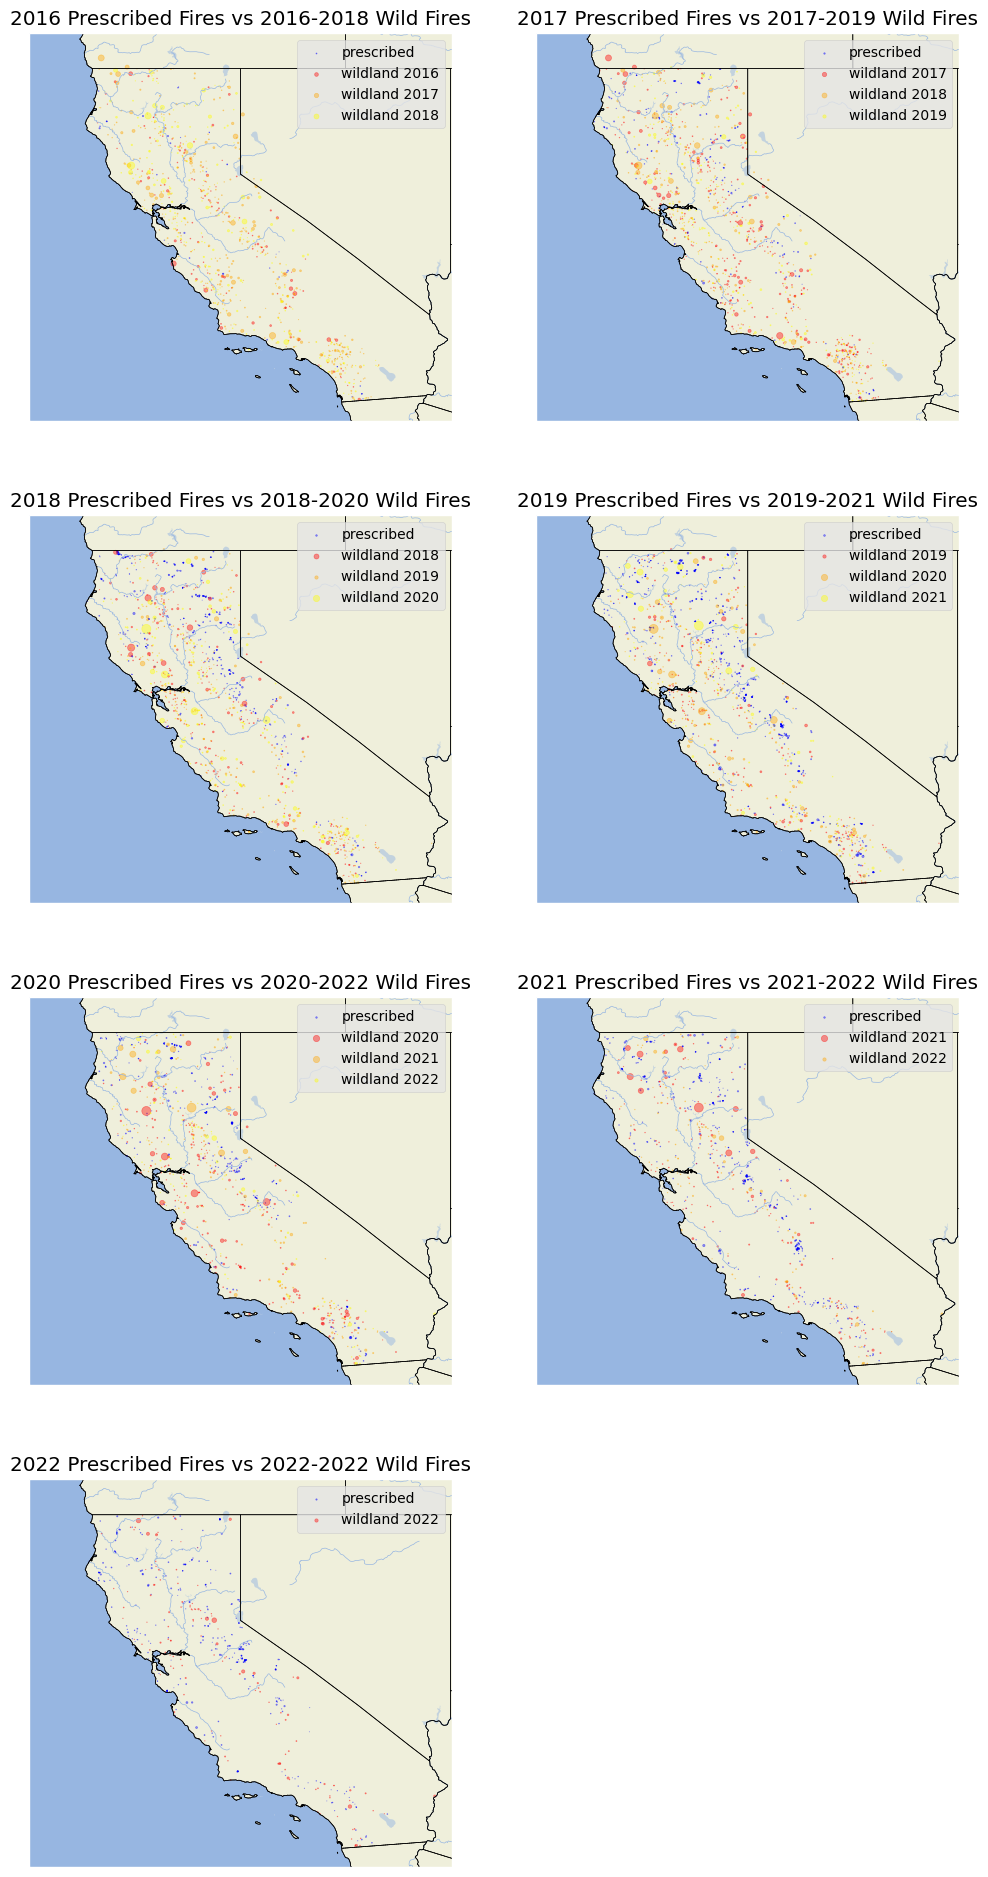

In [13]:
_ = plot_rx_wild_fires_multi_year(prescribed=gdf, wild=df, years=[2016, 2017, 2018, 2019, 2020, 2021, 2022])

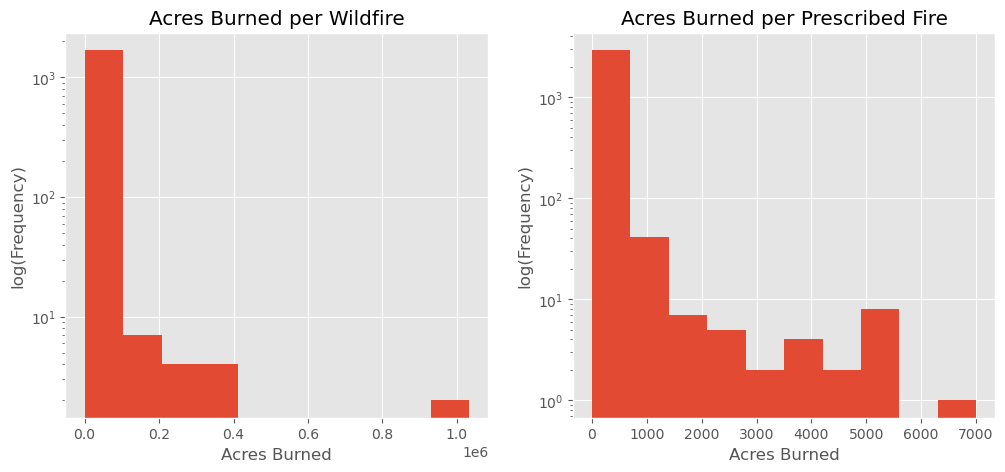

In [14]:
fig, ax = plt.subplots(1,2, figsize=(12,5))
hist, bins, _ = ax[0].hist(df["incident_acres_burned"].tolist(), log=True)
ax[0].set_title("Acres Burned per Wildfire")
ax[0].set_xlabel("Acres Burned")
ax[0].set_ylabel("log(Frequency)")

hist, bins, _ = ax[1].hist(gdf["TREATED_AC"].tolist(), log=True)
ax[1].set_title("Acres Burned per Prescribed Fire")
ax[1].set_xlabel("Acres Burned")
ax[1].set_ylabel("log(Frequency)")
plt.show()

## Monthly Dataset
- descriptive statistics
- timeseries (individual)
- scatter plots (paired)
- correlations

The timeseries plots show again that wildfire acres burned seems to increase over time. Additionally, soil moisture, precipitation, and the drought indices appear to decrease over time. The pairwise scatterplots have the wildfire acresburned on the top row. There are no strong trends between the predictors and the wildfire acres burned, though a few weak trends are observed. Lower soil moisture, lower precipitation, and lower numbers of prescribed acres burned appear to be related to greater numbers of acres burned, while high temperatures are related to greater numbers of acres burned. These trends are confirmed in the correlation matrix over months, though the years correlation matrix shows an opposite trend with prescribed acres.

In [15]:
def graph_timeseries(df, cols, logs, ylabs):
    df = df[cols]
    nrows = int(np.ceil(len(cols)/2))
    ncols = 2
    figsize_x = ncols*6
    figsize_y = nrows*3
    fig, ax = plt.subplots(nrows, ncols, figsize=(figsize_x,figsize_y))
    curr_row = 0
    curr_col = 0
    for i in range(len(cols)):
        ax[curr_row, curr_col].plot(df[cols[i]], label=cols[i])
        ax[curr_row, curr_col].xaxis.set_major_locator(mdates.YearLocator())
        ax[curr_row, curr_col].set_title("Monthly Time Series of "+cols[i])
        if logs[i]: 
            ax[curr_row, curr_col].set_yscale('log')
        ax[curr_row, curr_col].set_ylabel(ylabs[i])
        if curr_col  == 1: 
            curr_row += 1
            curr_col = 0
        else:
            curr_col += 1
    if curr_col != 0:
        fig.delaxes(ax[curr_row, curr_col])
    plt.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4,hspace=0.4)
    plt.show()
    return fig

In [16]:
# monthly data set
data = pd.read_csv("wildfire_data.csv", index_col=0)
data.index = pd.to_datetime(data.index)

In [17]:
# monthly dataset
data.describe().round(3)

,incident_acres_burned,TREATED_AC,acres_3_month,acres_6_month,acres_9_month,acres_12_month,soil moisture,temp_avg_Value,temp_avg_Anomaly,temp_min_Value,...,phdi_Value,phdi_Anomaly,pmdi_Value,pmdi_Anomaly,pzi_Value,pzi_Anomaly,cooling_daysValue,cooling_daysAnomaly,heating_daysValue,heating_daysAnomaly
count,84.000,84.000,84.000,84.000,84.000,84.000,84.000,84.000,84.000,84.000,...,84.000,84.000,84.000,84.000,84.000,84.000,84.000,84.000,84.000,84.000
mean,110344.929,4170.750,14379.915,26615.107,38647.748,50390.078,216.543,60.001,2.635,47.421,...,-2.001,-2.193,-1.804,-1.921,-0.615,-0.673,92.262,34.845,92.262,34.845
std,319136.911,4806.226,12163.250,19205.680,26424.994,32902.875,76.308,12.065,2.146,10.305,...,2.821,2.820,2.724,2.731,2.257,2.266,117.024,45.752,117.024,45.752
min,0.000,0.000,137.900,1715.560,2695.090,5609.827,94.634,40.600,-4.700,32.100,...,-7.040,-7.410,-7.040,-7.360,-4.320,-4.540,0.000,-15.000,0.000,-15.000
25%,45.000,630.317,5207.180,14298.513,19198.453,20710.220,156.934,48.725,1.400,38.075,...,-4.072,-4.188,-3.515,-3.503,-1.982,-1.972,1.000,0.000,1.000,0.000
50%,5663.000,2511.900,12218.114,23412.695,34314.523,46763.105,208.096,58.200,2.750,45.800,...,-2.485,-2.675,-2.000,-2.200,-0.885,-0.995,21.000,12.000,21.000,12.000
75%,70263.250,5729.942,19873.306,37332.757,49249.923,64374.166,258.927,71.600,4.125,57.100,...,-0.915,-1.080,-0.322,-0.388,0.222,0.262,173.250,50.500,173.250,50.500
max,2106955.000,26306.600,55120.180,76049.380,105581.310,127494.460,406.696,79.800,6.700,65.400,...,4.760,4.550,4.760,4.660,7.100,6.880,377.000,167.000,377.000,167.000


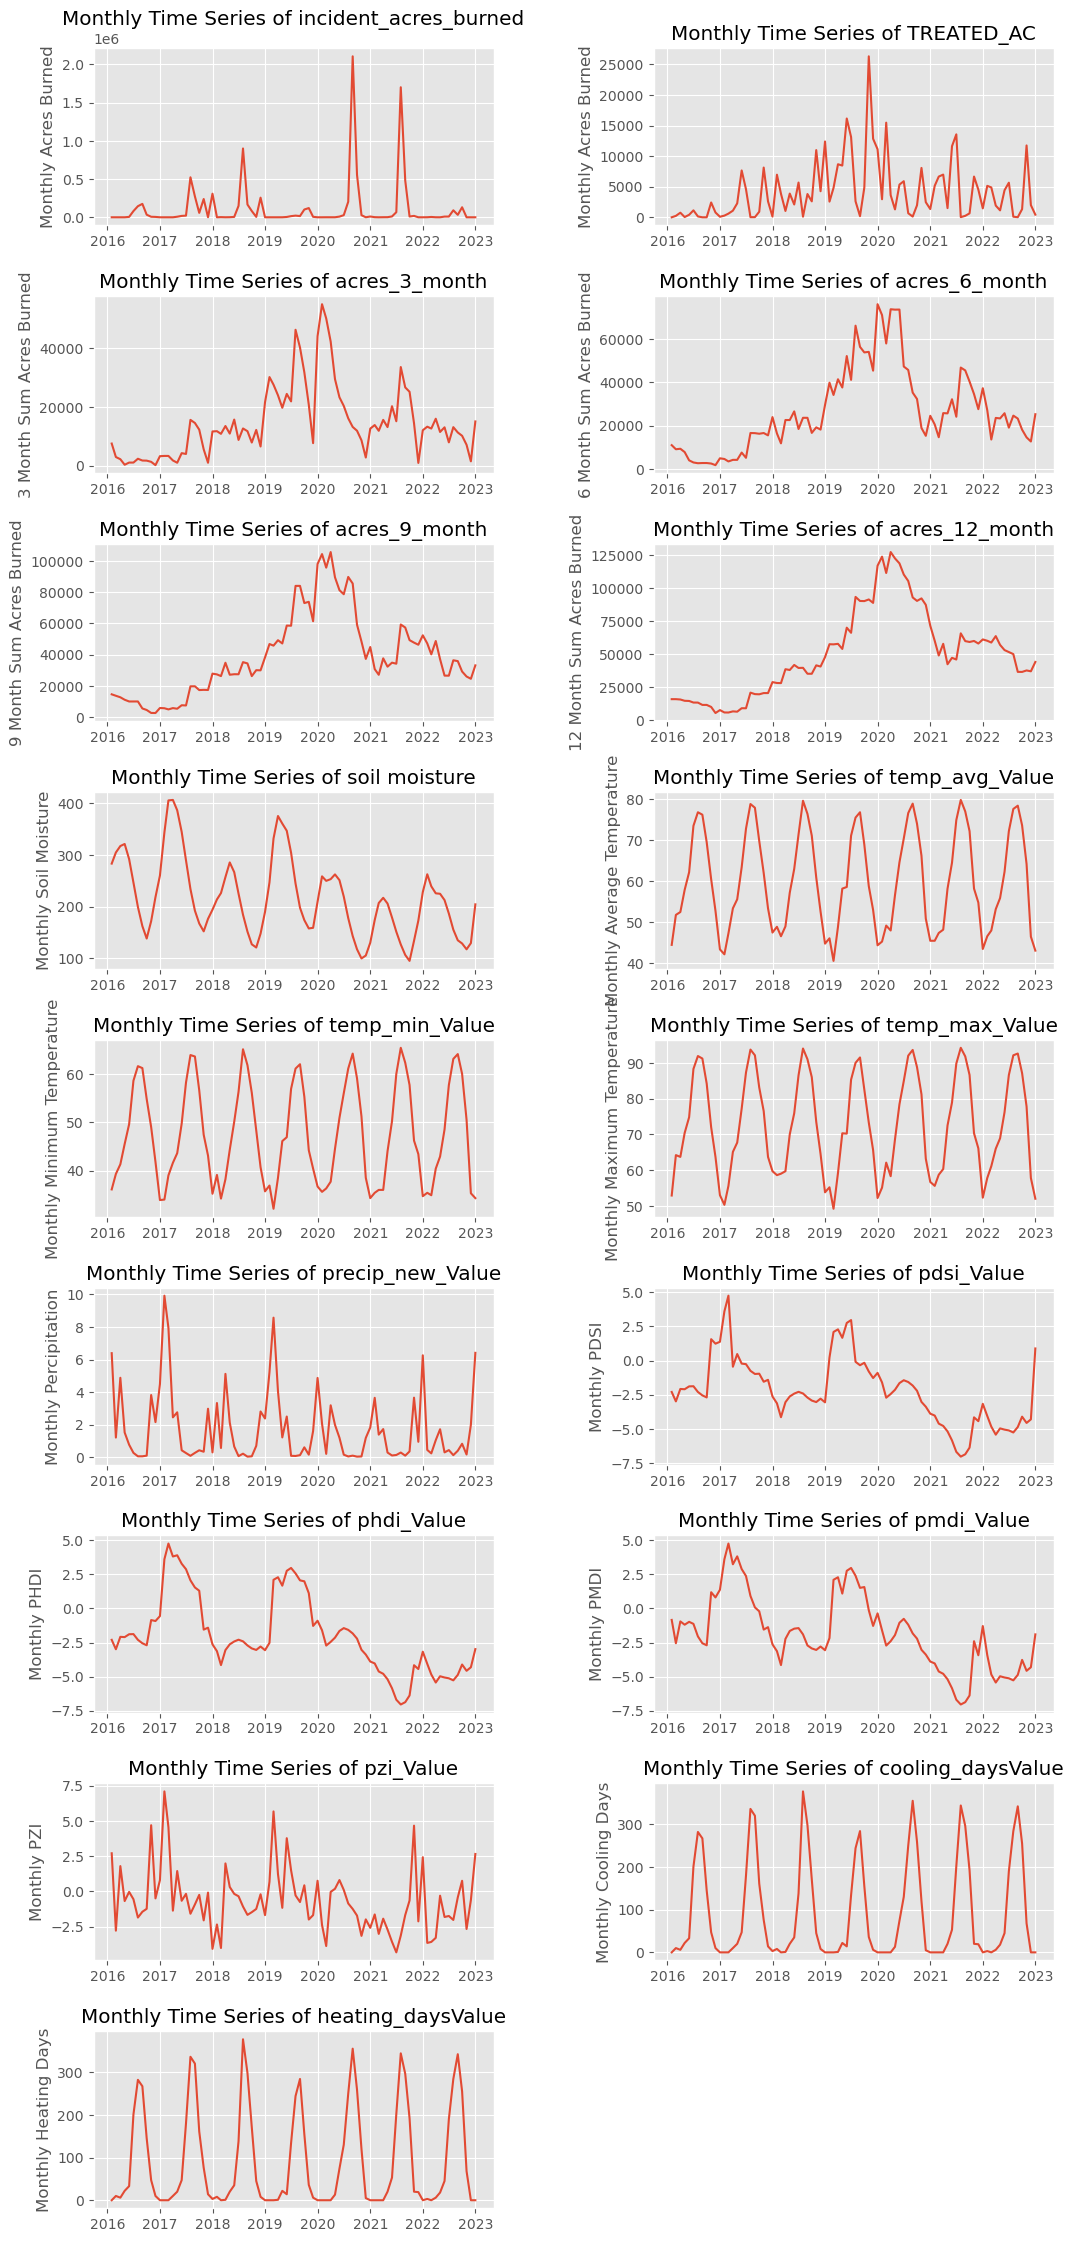

In [18]:
ylabs = ["Monthly Acres Burned", "Monthly Acres Burned", "3 Month Sum Acres Burned", "6 Month Sum Acres Burned",
         "9 Month Sum Acres Burned", "12 Month Sum Acres Burned","Monthly Soil Moisture",
         "Monthly Average Temperature", "Monthly Minimum Temperature", "Monthly Maximum Temperature", "Monthly Percipitation",
         "Monthly PDSI",  "Monthly PHDI",  "Monthly PMDI",  "Monthly PZI", "Monthly Cooling Days", "Monthly Heating Days"]
logs = [False] +[False for i in range(1, len(ylabs))]
cols = [col for col in data.columns if "Anomaly" not in col]
_ = graph_timeseries(data, cols, logs, ylabs)

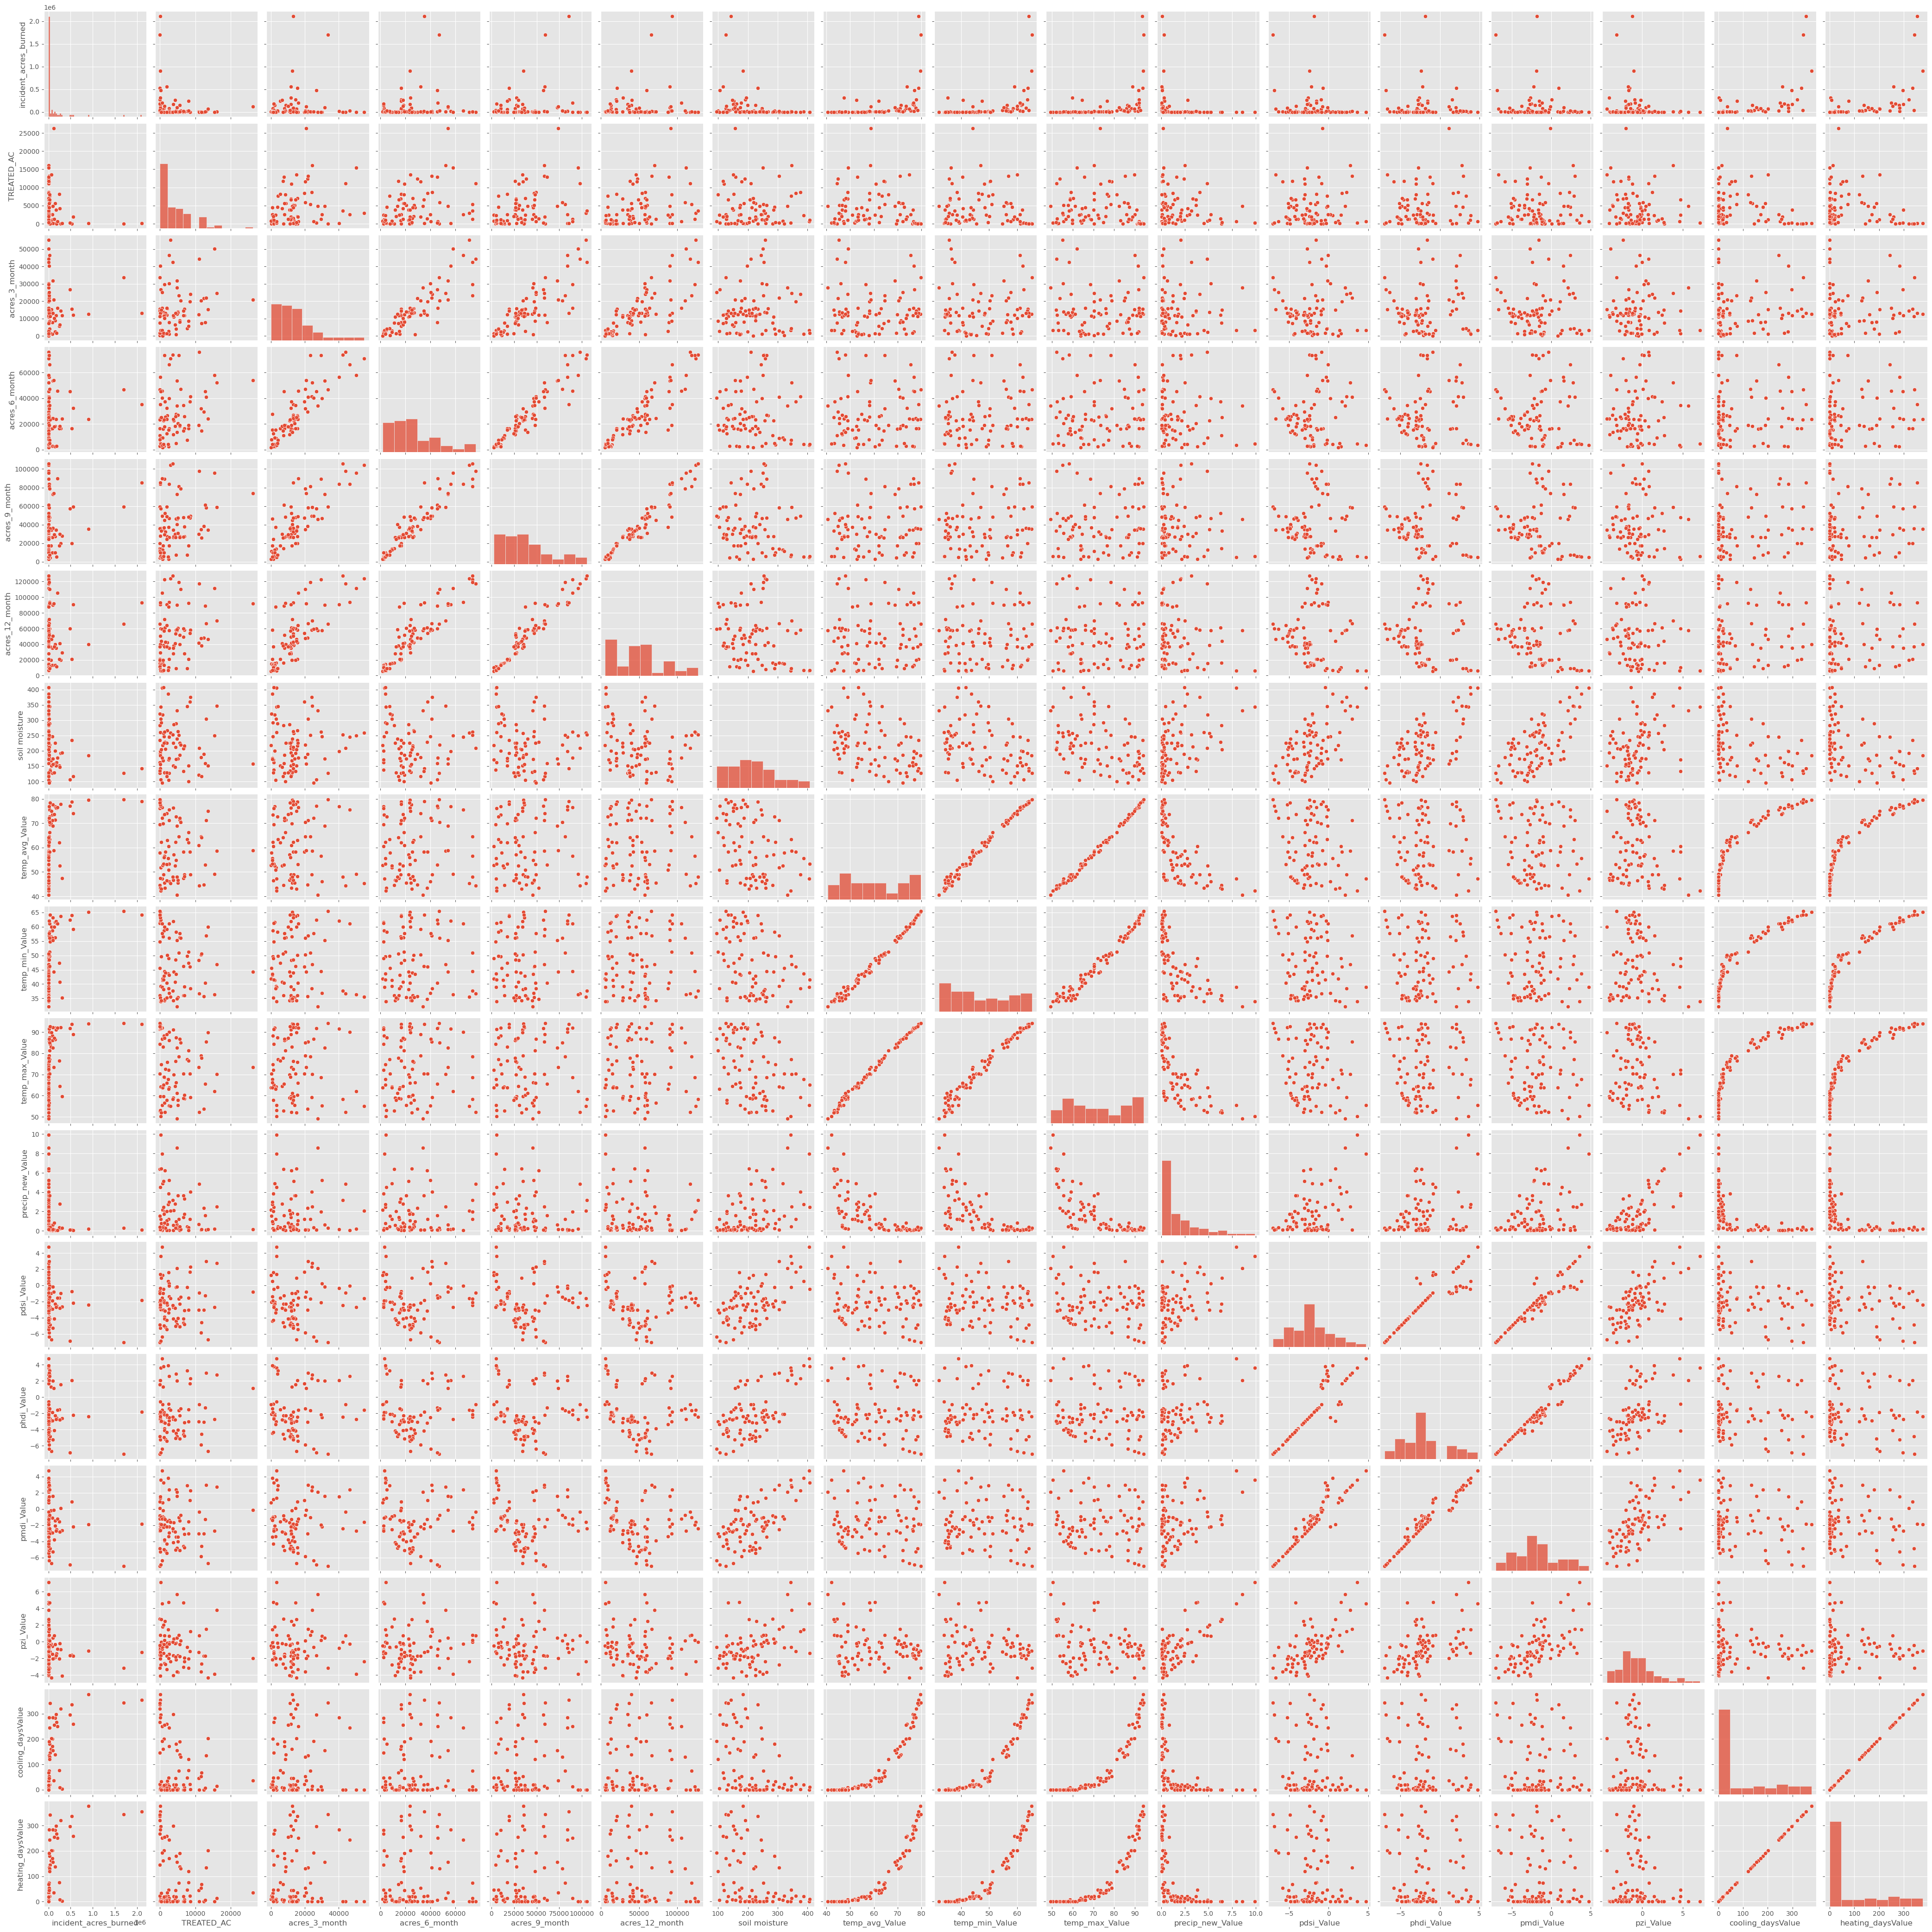

In [19]:
import seaborn as sns

sns.pairplot(data[cols])

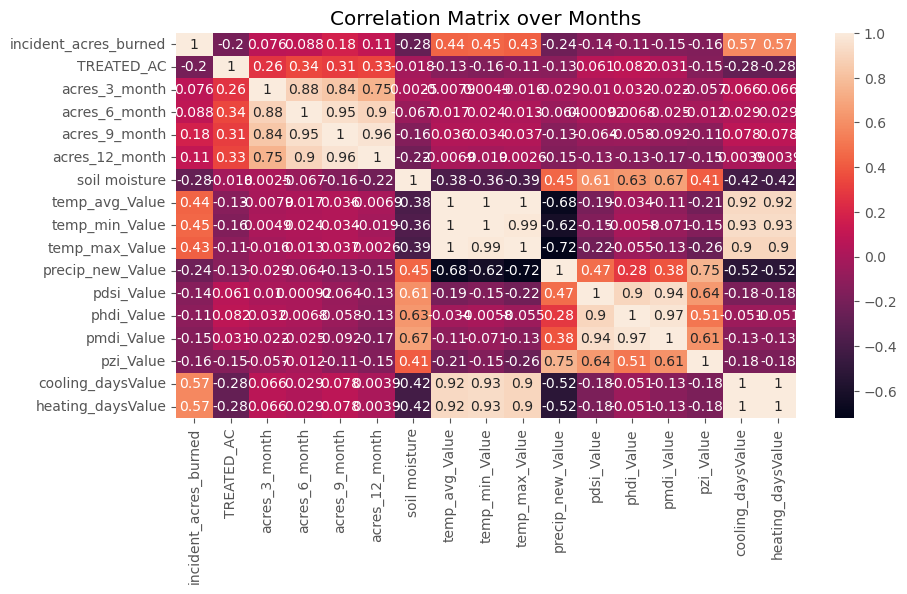

In [20]:
corr_matrix = data[cols].corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix over Months")
plt.show()

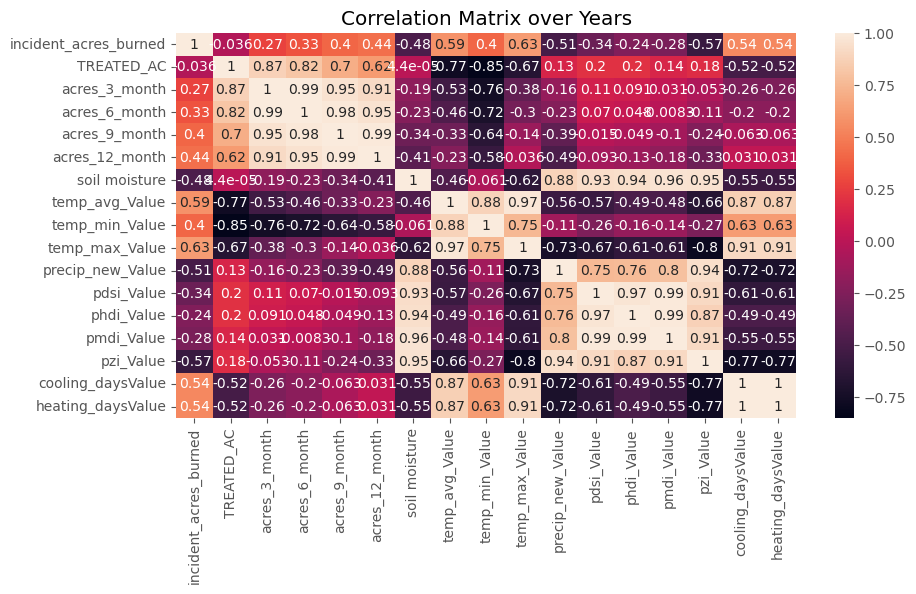

In [21]:
annual = data[cols].resample('Y').sum()
corr_matrix = annual.corr()
plt.figure(figsize=(10,5))
sns.heatmap(corr_matrix, annot=True)
plt.title("Correlation Matrix over Years")
plt.show()

# Discussion

From the initial exploration of the dataset a few predictors are identified as possibly being related to wildfire acres burned. In particular, soil moisture, temperature, precipitation, and the drought indices seem to have a clear relationship with wildfire acres burned. The relationship between prescribed fires and wildland fires is less clear, though the correlation matrix indicates a slight relationship where increases in prescribed fires may decrease wildfire acres. Additional data processing, including variable transformation, min-max scaling, and feature engineering should be performed prior to training and testing models.